In [1]:
import scipy.io
data = scipy.io.loadmat('../../data/url.mat')
#'../../data/url.mat'

**create list for labels and data, where one entry is the data for the day with this index**

In [2]:
import numpy as np

num_of_days = 120
X, Y = [], []

for i in range(num_of_days):
    day_data = data["Day" + str(i)]
    X.append(day_data[0][0][0])
    Y.append(day_data[0][0][1])

In [3]:
for i in range(len(Y)):
    Y[i] = Y[i].ravel()

**continous learn classifier**

In [4]:
def fix_features(X, fixed_features_amount = 150000):
    select_ind = np.arange(0, fixed_features_amount)
    return X[:,select_ind]

In [5]:
# incremental learns classifier (must have partial_fit() function)
# returns an array of cumulative error rates for each day
def learn_incremental(clf, is_fixed, batch_size = 1000):
    
    error_rates = []
    num_of_days = 120
    err = 0
    
    for curr_day in range(num_of_days): # looping through days
    
        if (curr_day != 45):
            
            if (is_fixed):
                X_curr_day = fix_features(X[curr_day])
            else:
                X_curr_day = X[curr_day]
    
            # split the data in slices of batch_size
            batches_amount = int(X_curr_day.shape[0] / batch_size)
            Y_curr_day = np.array_split(Y[curr_day], batches_amount)
    
            for j in range(batches_amount): # looping through individual urls
                select_ind = np.arange(j * batch_size, (j+1) * batch_size)
        
                X_curr_url_batch, Y_curr_url_batch = X_curr_day[select_ind,:], Y_curr_day[j] 
        
                # flatten y to 1d
                Y_curr_url_batch = Y_curr_url_batch.ravel()
        
                if (j > 0):
                    Y_preds = clf.predict(X_curr_url_batch)
            
                    for k in range(batch_size):
                        if(Y_preds[k] != Y_curr_url_batch[k]):
                            err = err + 1
        
                clf.partial_fit(X_curr_url_batch, Y_curr_url_batch, classes=list(range(2))) # Continous fitting of urls and label
            
            error_rates.append(err / X_curr_day.shape[0])
            err = 0
    return error_rates

### Batch-size and other global variables and imports:

In [6]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
import matplotlib.pyplot as plt

batch_size = 4

# Initialize error rates of the different classifiers
error_rates_pa = None
error_rates_percep = None
error_rates_pa_ff = None
error_rates_percep_ff = None

### Perceptron

In [7]:
clf = Perceptron(random_state = 123)

error_rates_percep = learn_incremental(clf, False, batch_size)

cnt = 0
for x in error_rates_percep:    
    print("Error-rate Day {}   : {}".format(cnt, x))
    cnt = cnt + 1

Error-rate Day 0   : 0.051375
Error-rate Day 1   : 0.03565
Error-rate Day 2   : 0.0252
Error-rate Day 3   : 0.0267
Error-rate Day 4   : 0.0305
Error-rate Day 5   : 0.0239
Error-rate Day 6   : 0.0233
Error-rate Day 7   : 0.02805
Error-rate Day 8   : 0.02575
Error-rate Day 9   : 0.03235
Error-rate Day 10   : 0.029
Error-rate Day 11   : 0.02535
Error-rate Day 12   : 0.02515
Error-rate Day 13   : 0.0192
Error-rate Day 14   : 0.0241
Error-rate Day 15   : 0.0184
Error-rate Day 16   : 0.0221
Error-rate Day 17   : 0.0204
Error-rate Day 18   : 0.02065
Error-rate Day 19   : 0.0184
Error-rate Day 20   : 0.0194
Error-rate Day 21   : 0.02545
Error-rate Day 22   : 0.0216
Error-rate Day 23   : 0.02355
Error-rate Day 24   : 0.0276
Error-rate Day 25   : 0.0294
Error-rate Day 26   : 0.0171
Error-rate Day 27   : 0.02115
Error-rate Day 28   : 0.0226
Error-rate Day 29   : 0.0245
Error-rate Day 30   : 0.0292
Error-rate Day 31   : 0.0255
Error-rate Day 32   : 0.0259
Error-rate Day 33   : 0.02375
Error-rate D

### Passive Aggressive

In [8]:
clf = PassiveAggressiveClassifier(C=0.001, random_state = 123)

error_rates_pa = learn_incremental(clf, False, batch_size)

cnt = 0
for x in error_rates_pa:    
    print("Error-rate Day {}   : {}".format(cnt, x))
    cnt = cnt + 1

Error-rate Day 0   : 0.0489375
Error-rate Day 1   : 0.0315
Error-rate Day 2   : 0.02365
Error-rate Day 3   : 0.0229
Error-rate Day 4   : 0.0265
Error-rate Day 5   : 0.02545
Error-rate Day 6   : 0.0226
Error-rate Day 7   : 0.0259
Error-rate Day 8   : 0.0235
Error-rate Day 9   : 0.02865
Error-rate Day 10   : 0.0251
Error-rate Day 11   : 0.02235
Error-rate Day 12   : 0.02365
Error-rate Day 13   : 0.01875
Error-rate Day 14   : 0.02365
Error-rate Day 15   : 0.01895
Error-rate Day 16   : 0.02015
Error-rate Day 17   : 0.01955
Error-rate Day 18   : 0.01985
Error-rate Day 19   : 0.0183
Error-rate Day 20   : 0.0204
Error-rate Day 21   : 0.0265
Error-rate Day 22   : 0.0226
Error-rate Day 23   : 0.02485
Error-rate Day 24   : 0.0273
Error-rate Day 25   : 0.02665
Error-rate Day 26   : 0.0177
Error-rate Day 27   : 0.02355
Error-rate Day 28   : 0.0214
Error-rate Day 29   : 0.02335
Error-rate Day 30   : 0.03085
Error-rate Day 31   : 0.0264
Error-rate Day 32   : 0.0256
Error-rate Day 33   : 0.0253
Error

### Perceptron fixed features

In [9]:
clf = Perceptron(random_state = 123)
error_rates_percep_ff = learn_incremental(clf, True, batch_size)

cnt = 0
for x in error_rates_percep_ff:    
    print("Error-rate Day {}   : {}".format(cnt, x))
    cnt = cnt + 1

Error-rate Day 0   : 0.0475
Error-rate Day 1   : 0.0347
Error-rate Day 2   : 0.02435
Error-rate Day 3   : 0.02605
Error-rate Day 4   : 0.0294
Error-rate Day 5   : 0.0239
Error-rate Day 6   : 0.0226
Error-rate Day 7   : 0.027
Error-rate Day 8   : 0.0249
Error-rate Day 9   : 0.03135
Error-rate Day 10   : 0.0285
Error-rate Day 11   : 0.0227
Error-rate Day 12   : 0.022
Error-rate Day 13   : 0.0181
Error-rate Day 14   : 0.02195
Error-rate Day 15   : 0.01785
Error-rate Day 16   : 0.02075
Error-rate Day 17   : 0.01965
Error-rate Day 18   : 0.01945
Error-rate Day 19   : 0.0166
Error-rate Day 20   : 0.0209
Error-rate Day 21   : 0.0247
Error-rate Day 22   : 0.0228
Error-rate Day 23   : 0.0248
Error-rate Day 24   : 0.0283
Error-rate Day 25   : 0.03
Error-rate Day 26   : 0.01705
Error-rate Day 27   : 0.02125
Error-rate Day 28   : 0.02205
Error-rate Day 29   : 0.02445
Error-rate Day 30   : 0.02805
Error-rate Day 31   : 0.02305
Error-rate Day 32   : 0.0232
Error-rate Day 33   : 0.0231
Error-rate Day

### Passive Aggressive fixed features

In [10]:
clf = PassiveAggressiveClassifier(C=0.001, random_state = 123)
error_rates_pa_ff = learn_incremental(clf, True, batch_size)

cnt = 0
for x in error_rates_pa_ff:    
    print("Error-rate Day {}   : {}".format(cnt, x))
    cnt = cnt + 1

Error-rate Day 0   : 0.0598125
Error-rate Day 1   : 0.0384
Error-rate Day 2   : 0.03135
Error-rate Day 3   : 0.0276
Error-rate Day 4   : 0.0314
Error-rate Day 5   : 0.02945
Error-rate Day 6   : 0.0258
Error-rate Day 7   : 0.0298
Error-rate Day 8   : 0.02615
Error-rate Day 9   : 0.0317
Error-rate Day 10   : 0.02865
Error-rate Day 11   : 0.02545
Error-rate Day 12   : 0.0255
Error-rate Day 13   : 0.02065
Error-rate Day 14   : 0.02585
Error-rate Day 15   : 0.0208
Error-rate Day 16   : 0.0226
Error-rate Day 17   : 0.0232
Error-rate Day 18   : 0.0232
Error-rate Day 19   : 0.02
Error-rate Day 20   : 0.02305
Error-rate Day 21   : 0.0301
Error-rate Day 22   : 0.02705
Error-rate Day 23   : 0.0267
Error-rate Day 24   : 0.03055
Error-rate Day 25   : 0.02935
Error-rate Day 26   : 0.02175
Error-rate Day 27   : 0.0261
Error-rate Day 28   : 0.024
Error-rate Day 29   : 0.0258
Error-rate Day 30   : 0.03315
Error-rate Day 31   : 0.03015
Error-rate Day 32   : 0.0284
Error-rate Day 33   : 0.0282
Error-rate

In [11]:
def cleanup(x, y):
    
    # Cleanup outliers in data
    outliers = []
    for i in range(len(y)):
        if (y[i] > 3.5 or y[i] < 0.5):
            outliers = np.append(outliers, i)
    
    offset = 0
    for outl in outliers:
        y = np.delete(y, int(outl) - offset)
        x = x[:-1]
        offset = offset + 1
        
    return x, y

In [12]:
def _calc_line(x, y):
    
    # create polynomial equation and calculate line
    theta = np.polyfit(x, y, 8)
    return theta[8] + theta[7] * pow(x, 1) + theta[6] * pow(x, 2) + theta[5] * pow(x, 3) + theta[4] * pow(x, 4) + theta[3] * pow(x, 5) + theta[2] * pow(x, 6) + theta[1] * pow(x, 7) + theta[0] * pow(x, 8)

In [13]:
def _plot(y, color, marker, linestyle, scatter, label):
    
    # Set up the day_indexes with the missing 45th day in mind
    x = np.arange(0, 120) 
    
    # attend to data size imbalances (day 45 outages)
    if (y.shape[0] < x.shape[0]):
        x = x[:-1]
    
    y = y * 100
    #x, y = cleanup(x, y)
    
    if (scatter):
        plt.scatter(x, y)
    
    y = _calc_line(x, y)
    plt.plot(x, y, "{}{}{}".format(marker, color, linestyle), markevery=5, label=label)

In [14]:
def plot8degree(error_rates_pa, error_rates_percep, 
                error_rates_pa_ff, error_rates_percep_ff,
                batch_size, scatter = False):

    
    if (error_rates_pa is not None):
        _plot(np.array(error_rates_pa), 'r', 'v', '-', scatter, "PA")
        
    if (error_rates_percep is not None):
        _plot(np.array(error_rates_percep), 'g', 'o', '-', scatter, "Perceptron")
        
    if (error_rates_pa_ff is not None):
        _plot(np.array(error_rates_pa_ff), 'm', '^', '--',scatter, "PA (fixed)")
        
    if (error_rates_percep_ff is not None):
        _plot(np.array(error_rates_percep_ff), 'b', 'x', '--', scatter, "Percep. (fixed)") 
    
    title = 'Experiment 3 (fixed-feature) with batch size {}'.format(batch_size)
    plt.title(title)
    plt.xlabel('Days')
    plt.ylabel('Cumulative error rate (%)')
    plt.ylim([1,4])
    plt.xlim([0,100])
    plt.legend()
    plt.savefig("{}.svg".format(title), format='svg', dpi=1200)

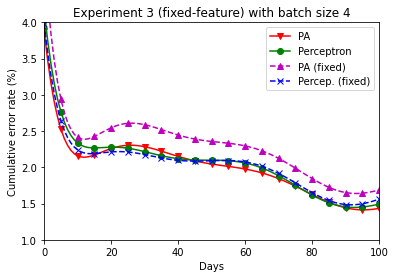

In [15]:
plot8degree(error_rates_pa, error_rates_percep, 
                error_rates_pa_ff, error_rates_percep_ff, batch_size, False)

In [16]:
# Better results without cleanup